In [83]:
#!/usr/bin/env python

# Copyright 2016, Rohan Dandage <rraadd_8@hotmail.com>
# This program is distributed under General Public License v. 3.    

import sys
from os.path import exists
import nd2reader
import pandas as pd
import string
import numpy as np
from scipy import stats
import os
from multiprocessing import Pool
from os.path import splitext,basename
import cv2
from skimage.segmentation import random_walker
# from skimage.data import binary_blobs
from skimage import io,exposure,restoration,filters,morphology,measure
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [187]:
def nd2arr_list(nd_dh,nd_fns):
    arr_list=[]
    for nd_fn in nd_fns:
        nd = nd2reader.Nd2("%s/%s" % (nd_dh,nd_fn))
        for ndi in nd:
            arr_list.append(np.array(ndi))
        del nd
    return arr_list

def raw2phasecorr(arr_list):
    cx = 0.0
    cy = 0.0
    stb_arr_list=[]
    prev_image = np.float32(arr_list[0]) #ref
    for frame in arr_list:
        image = np.float32(frame)
        # TODO: set window around phase correlation
        dp = cv2.phaseCorrelate(prev_image, image)
        cx = cx - dp[0]
        cy = cy - dp[1]
        xform = np.float32([[1, 0, cx], [0, 1, cy]])
        stable_image = cv2.warpAffine(image, xform, dsize=(image.shape[1], image.shape[0]))
        prev_image = image
        #clip sides
        ht,wd=np.shape(stable_image)
        clip=0.125 #0.25
        lt=int(wd*clip)
        rt=int(wd-wd*clip)
        up=int(ht*clip)
        dw=int(ht-ht*clip)
        stable_image_clipped=stable_image[up:dw,lt:rt]
        stb_arr_list.append(stable_image_clipped)
    return stb_arr_list

def arr_list2regions(arr_list):
    pre_bleach=arr_list_stb[0]
    smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
    markers = np.zeros(smoothened.shape, dtype=np.uint)
    markers[smoothened < filters.threshold_otsu(smoothened)] = 1
    markers[smoothened > filters.threshold_otsu(smoothened)] = 2
    labels = random_walker(smoothened, markers, beta=10, mode='bf')
    regions= measure.label(labels)
    label_objects, nb_labels = ndi.label(regions)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 100
    mask_sizes[0] = 0
    regions_cleaned = mask_sizes[label_objects]
    return regions_cleaned

def arr_list2vid(regions,arr_list,vid_fh,xpixels, ypixels):
    dpi = 100
#     xpixels, ypixels = 512, 512
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1, 1])
    fig.add_axes(ax)
    ax.set_axis_off()
    ax.set_aspect('equal')
    # plt.savefig('test.png')
#     def update_img(n):
#         tmp = arr_list[n]
#         im.set_data(tmp)
#         return im
#     # #legend(loc=0)
#     ani = animation.FuncAnimation(fig,update_img,np.arange(1,len(arr_list)),interval=60,blit=False)
#     writer = animation.writers['ffmpeg'](fps=4)
#     ani.save(vid_fh,writer=writer)#dpi=dpi

    ims=[]
    for i in range(len(arr_list)):
    im=plt.imshow(pre_bleach,cmap='gray',animated=True)
    im=plt.contour(regions_cleaned, [0.5], linewidths=1.2, colors='r',animated=False)
    ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=60, blit=True)
#                                     repeat_delay=1000)
    ani.save(vid_fh)

In [188]:
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160309_sdsd_replicates/160309_sdsd_replicates.xlsx'
well='A03'

In [189]:
info=pd.read_excel(fh_xls,'info')
info=info.set_index('varname')
for var in info.iterrows() :
    val=info['input'][var[0]]
    if not pd.isnull(val):
        exec("%s=info['input']['%s']" % (var[0],var[0]),locals(), globals())
    else:
        exec("%s=info['default']['%s']" % (var[0],var[0]),locals(), globals())

data_job=pd.read_excel(fh_xls,'JobView')
data_fns=pd.pivot_table(data_job,values='File Name',index='Loop_bleach Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns_P =pd.pivot_table(data_job,values='File Name',index='TimeLapse1 Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns   =pd.concat([data_fns,data_fns_P],axis=0)

wells=[str(x) for x in list(data_job['Well Name'].unique())]
if not any(x in well for x in wells):
    print >> sys.stderr, "### ERROR : Could not find '%s'!" % well
    sys.exit(1)

In [107]:
if not exists("%s.%s.mp4" % (fh_xls,well)):
    print ">>> STATUS  : nd2vid : %s" % well 
    nd_fns=data_fns[well].dropna().unique()
    arr_list=nd2arr_list(nd_dh,nd_fns)
    arr_list_stb=raw2phasecorr(arr_list)
    regions=arr_list2regions(arr_list_stb)
    arr_list2vid(regions,arr_list_stb,fh_xls+'.mp4',384, 384)
else:
    print ">>> STATUS  : nd2vid :already done"

>>> STATUS  : nd2vid : A03


In [185]:
pre_bleach=arr_list_stb[0]
smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
markers = np.zeros(smoothened.shape, dtype=np.uint)
markers[smoothened < filters.threshold_otsu(smoothened)] = 1
markers[smoothened > filters.threshold_otsu(smoothened)] = 2
labels = random_walker(smoothened, markers, beta=10, mode='bf')
regions= measure.label(labels)
# plt.imshow(regions,cmap='jet')
label_objects, nb_labels = ndi.label(regions)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 100
mask_sizes[0] = 0
regions_cleaned = mask_sizes[label_objects]

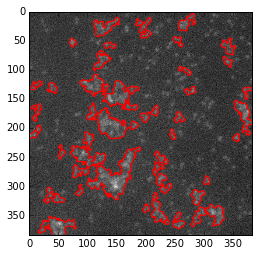

In [192]:
im=plt.imshow(pre_bleach,cmap='gray')
im=plt.contour(regions_cleaned, [0.5], linewidths=1.2, colors='r')

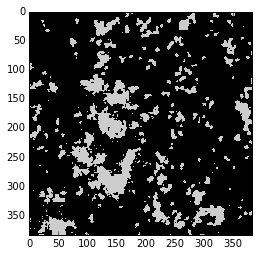

In [126]:
from skimage.filters import sobel
from skimage import img_as_float
# pre_bleach_float = img_as_float(pre_bleach.astype('float64'))
image=pre_bleach.astype('float64')
elevation_map = sobel(image)
smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
markers = np.zeros_like(image)
markers[smoothened < filters.threshold_otsu(smoothened)] = 1
markers[smoothened > filters.threshold_otsu(smoothened)] = 2
segmentation = morphology.watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.spectral, interpolation='nearest')